<a href="https://colab.research.google.com/github/Yuvashri2912/Yuvashri/blob/main/shri_NM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Merged Data (Head):
   userId  movieId  rating   timestamp  \
0       1       16     4.0  1217897793   
1       1       24     1.5  1217895807   
2       1       32     4.0  1217896246   
3       1       47     4.0  1217896556   
4       1       50     4.0  1217896523   

                                       title                   genres  
0                              Casino (1995)              Crime|Drama  
1                              Powder (1995)             Drama|Sci-Fi  
2  Twelve Monkeys (a.k.a. 12 Monkeys) (1995)  Mystery|Sci-Fi|Thriller  
3                Seven (a.k.a. Se7en) (1995)         Mystery|Thriller  
4                 Usual Suspects, The (1995)   Crime|Mystery|Thriller  

Merged Data (Tail):
        userId  movieId  rating   timestamp                   title  \
105334     668   142488     4.0  1451535844        Spotlight (2015)   
105335     668   142507     3.5  1451535889   Pawn Sacrifice (2015)   
105336     668   143385     4.0  1446388585  Bridge of Spies 

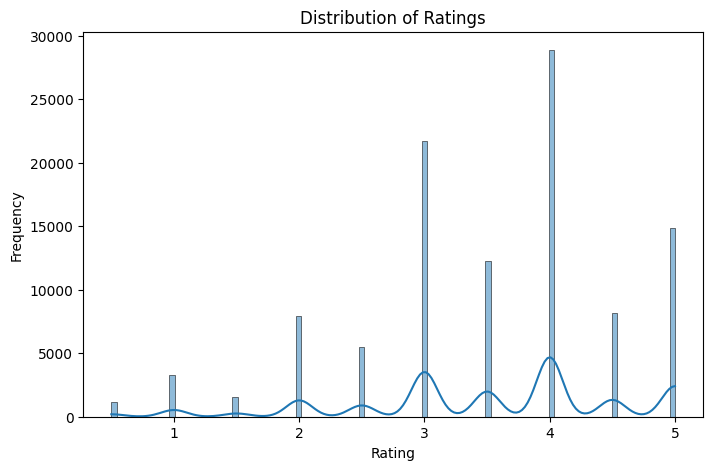


--- Bivariate Analysis ---

Top 10 Movies by Average Rating:
412                              Heaven & Earth (1993)
1854                             Hard Core Logo (1996)
2653                       Bride of the Monster (1955)
2824                                  Limelight (1952)
2866                                 Possession (1981)
8486                        Flesh and the Devil (1926)
8881     Castaway on the Moon (Kimssi pyoryugi) (2009)
10283                              The Revenant (2015)
10285               Everything's Gonna Be Great (1998)
10300                                       Air (2015)
Name: title, dtype: object


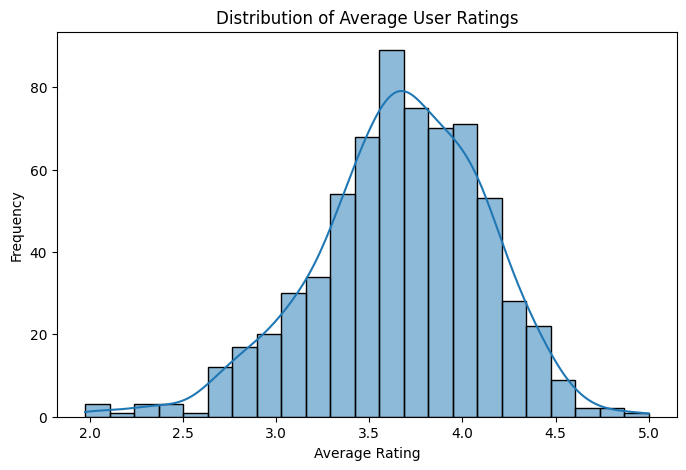


--- Multivariate Analysis ---


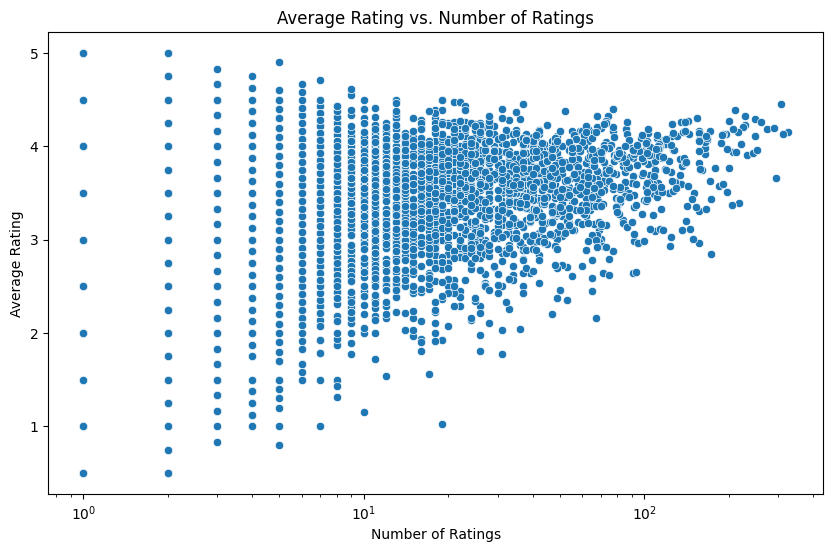


Selected Top 3 Features: ['movie_rating_count', 'movie_avg_rating', 'user_avg_rating']


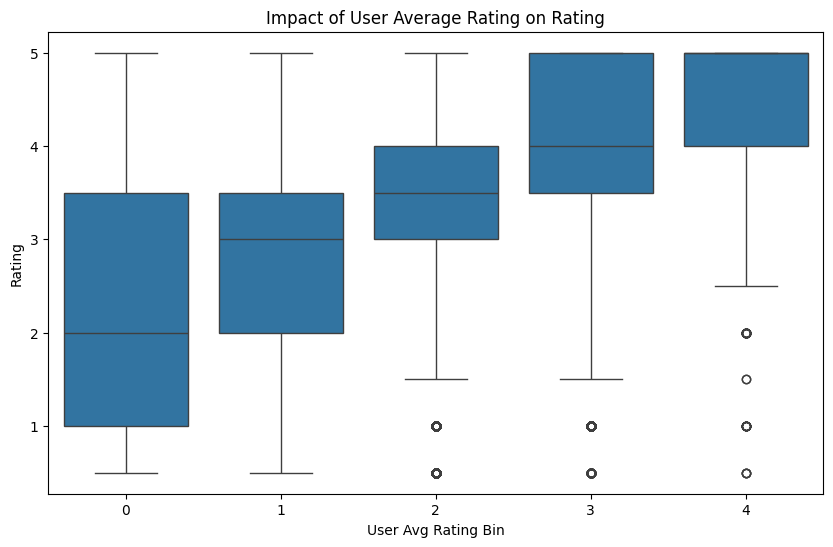


--- Evaluating Linear Regression ---
Linear Regression MSE: 0.6456
Linear Regression RMSE: 0.8035
Linear Regression MAE: 0.6153
Linear Regression R2 Score: 0.4038

--- Evaluating Random Forest Regression ---
Random Forest MSE: 0.6688
Random Forest RMSE: 0.8178
Random Forest MAE: 0.6160
Random Forest R2 Score: 0.3823


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Load Data ---
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# --- Merge Data ---
merged_data = pd.merge(ratings, movies, on='movieId')

# Display head and tail
print("Merged Data (Head):")
print(merged_data.head())
print("\nMerged Data (Tail):")
print(merged_data.tail())

# Join head and tail for quick view
joined = pd.concat([merged_data.head(5), merged_data.tail(5)])
print("\nCombined Head and Tail:")
print(joined)

# --- Exploratory Data Analysis (EDA) ---

# Univariate Analysis
print("\n--- Univariate Analysis ---")
print("\nMovies Data (Numerical):")
print(movies.describe())
print("\nRatings Data (Numerical):")
print(ratings.describe())
print("\nMovies Data (Non-Numerical):")
print(movies.describe(include='object'))

# Plot rating distribution
plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Bivariate Analysis
print("\n--- Bivariate Analysis ---")
avg_ratings = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
print("\nTop 10 Movies by Average Rating:")
print(movies[movies['movieId'].isin(avg_ratings.head(10).index)]['title'])

# Plot user average ratings
user_avg_ratings = ratings.groupby('userId')['rating'].mean()
plt.figure(figsize=(8, 5))
sns.histplot(user_avg_ratings, kde=True)
plt.title('Distribution of Average User Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Multivariate Analysis
print("\n--- Multivariate Analysis ---")
ratings_count = ratings.groupby('movieId')['rating'].count()
movie_stats = pd.DataFrame({'average_rating': avg_ratings, 'rating_count': ratings_count})
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating_count', y='average_rating', data=movie_stats)
plt.title('Average Rating vs. Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.xscale('log')
plt.show()

# --- Feature Engineering ---
merged_data = pd.merge(ratings, movies, on='movieId')
movie_stats = merged_data.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()
movie_stats.columns = ['movieId', 'movie_rating_count', 'movie_avg_rating']
merged_data = pd.merge(merged_data, movie_stats, on='movieId', how='left')

user_avg_rating = merged_data.groupby('userId')['rating'].mean().reset_index(name='user_avg_rating')
merged_data = pd.merge(merged_data, user_avg_rating, on='userId', how='left')

# --- Feature Selection ---
features_to_consider = ['userId', 'movieId', 'movie_rating_count', 'movie_avg_rating', 'user_avg_rating']
data_for_selection = merged_data.dropna(subset=features_to_consider + ['rating']).copy()

if not data_for_selection.empty:
    X = data_for_selection[features_to_consider]
    y = data_for_selection['rating']
    X = X.replace([float('inf'), float('-inf')], pd.NA).dropna()
    y = y[X.index]

    if not X.empty:
        selector = SelectKBest(score_func=f_regression, k=3)
        selector.fit(X, y)
        selected_features = X.columns[selector.get_support(indices=True)].tolist()
        print("\nSelected Top 3 Features:", selected_features)
    else:
        print("\nNo valid data for feature selection after cleaning.")
        selected_features = []
else:
    print("\nNo valid data for feature selection.")
    selected_features = []

# --- Feature Impact Visualization ---
if 'user_avg_rating' in merged_data.columns and not merged_data['user_avg_rating'].isnull().all():
    merged_data['user_avg_rating_bin'] = pd.cut(merged_data['user_avg_rating'], bins=5, labels=False)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='user_avg_rating_bin', y='rating', data=merged_data.dropna(subset=['user_avg_rating_bin']))
    plt.title('Impact of User Average Rating on Rating')
    plt.xlabel('User Avg Rating Bin')
    plt.ylabel('Rating')
    plt.show()
    merged_data = merged_data.drop('user_avg_rating_bin', axis=1)
else:
    print("\nSkipping boxplot due to missing values.")

# --- Model Building and Evaluation ---

# Prepare modeling data
user_avg_rating = merged_data.groupby('userId')['rating'].mean().reset_index(name='user_avg_rating')
movie_avg_rating = merged_data.groupby('movieId')['rating'].mean().reset_index(name='movie_avg_rating')
merged_data = pd.merge(merged_data, user_avg_rating, on='userId', how='left')
merged_data = pd.merge(merged_data, movie_avg_rating, on='movieId', how='left')



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
print("\n--- Evaluating Linear Regression ---")
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

print(f"Linear Regression MSE: {mean_squared_error(y_test, y_pred_linear):.4f}")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_linear)):.4f}")
print(f"Linear Regression MAE: {mean_absolute_error(y_test, y_pred_linear):.4f}")
print(f"Linear Regression R2 Score: {r2_score(y_test, y_pred_linear):.4f}")

# Random Forest Regression
print("\n--- Evaluating Random Forest Regression ---")
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)

print(f"Random Forest MSE: {mean_squared_error(y_test, y_pred_rf):.4f}")
print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"Random Forest MAE: {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"Random Forest R2 Score: {r2_score(y_test, y_pred_rf):.4f}")